In [4]:
import pandas as pd
import os
import subprocess
from Comparative_Analysis import Utilities as util
from Bio import AlignIO
from tqdm.auto import tqdm
import re
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [5]:
project_dir = 'D:/Project_Data/Project_8'
r_scape_output_loc = project_dir + '/RScape_Run_Thoth'
intergenic_regions = util.list_dirs(r_scape_output_loc)

In [10]:
def overlap_metric(positions_1, positions_2):
    if len(positions_1) < len(positions_2):
        a = positions_1
        b = positions_2
    else:
        a = positions_2
        b = positions_1
    num_comparisons = len(a)
    num_overlaps = 0
    for coord_1 in a:
        for coord_2 in b:
            x, y = np.argsort(coord_1+coord_2)[:2] > 1
            if x != y:
                num_overlaps += 1
                break
    return 1 - num_overlaps / num_comparisons

In [11]:
ids =  util.list_dirs(r_scape_output_loc)
len(ids)

1784

In [15]:
overlap_metric([[0,100],[2000,3000]], [[40,50],[250,450],[0,1]])

0.5

In [29]:
positions_list = []
for id in ids:
    locus = id
    if os.path.isfile(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power'):
        with open(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power', 'r') as f:
            positions = []
            for l in f:
                if 'BPAIRS observed' in l:
                    if int(l.split('covary ')[1]) > 10:
                        positions = []
                        with open(r_scape_output_loc + '/' + id + '/search_hits_3.txt', 'r') as g:
                             for l in g:
                                if not(l[0] == '#'): 
                                    a = l.split()
                                    if a[16] == '!':
                                        if a[0] == 'NC_000962.3':
                                            positions.append((min(int(a[7]),int(a[8])), max(int(a[7]),int(a[8]))))
        if len(positions)>0:
            positions = set(positions)
            positions_list.append((locus, positions))
    

In [32]:
distance_matrix = np.zeros((len(positions_list), len(positions_list)))
for i, (locus, positions) in enumerate(positions_list):
    for j, (locus_2, positions_2) in enumerate(positions_list):
        distance_matrix[i,j] = overlap_metric(positions, positions_2)

In [33]:
clustering = AgglomerativeClustering(affinity="precomputed",  linkage = 'average', distance_threshold = 0.2, n_clusters = None).fit_predict(distance_matrix)
clustering

array([ 1, 37, 50, 63, 64, 49,  2,  6, 71, 19, 19,  1,  0, 12, 48, 12, 46,
       45,  3,  3,  3,  4,  0, 20,  1,  1, 18,  0, 58,  0,  0, 44,  0,  0,
        1, 69, 43,  1, 20, 85, 83, 81, 79,  0, 77,  8,  1, 66,  2, 75,  1,
        1, 73,  1, 72, 14, 14, 62, 70, 78,  8,  3,  0,  0, 13,  2,  9,  0,
        1,  5, 37, 67, 65, 82, 84,  8, 31,  1, 61,  3,  3, 59,  1,  3, 57,
       60, 55, 53, 51, 24,  2,  3,  3, 47, 22, 21, 68,  0, 41,  0,  3, 54,
       80,  1,  0,  1, 78, 13,  1,  1,  1,  1,  0,  1,  9,  5,  0, 76,  0,
        5, 26,  0, 35, 33,  5, 74,  5, 32, 29,  6,  1,  8,  2,  2,  1, 42,
        8,  0, 30, 36,  3, 56, 52,  0,  3, 23, 27, 10, 39, 38, 17, 34, 15,
       38,  0,  6, 16,  1,  0, 28, 11,  0, 40,  1,  5,  4, 18,  4,  1, 25,
        7], dtype=int64)

In [34]:
max(clustering)

85

In [35]:
cluster_hits = []
num_clusters = max(clustering) + 1
for i in range(num_clusters):
    num_coords = 0
    num_members = 0
    members = []
    
    for j, clust in enumerate(clustering):
        if clust == i:
            num_members +=1
            members.append(positions_list[j][0])
            num_coords += len(positions_list[j][1])
            co_ords = positions_list[j][1]        #  Just bring back last set as illustration 
        
    cluster_hits.append([i, num_coords/num_members, num_members, members, co_ords])

In [36]:
big_cluster_hits = [x for x in cluster_hits if x[1] > 10]
big_cluster_hits

[[0,
  122.56521739130434,
  23,
  ['Rv0383c',
   'Rv0570',
   'Rv0660c',
   'Rv0685',
   'Rv0686',
   'Rv0710',
   'Rv0712',
   'Rv0903c',
   'Rv1179c',
   'Rv1219c',
   'Rv1275',
   'Rv2176',
   'Rv2188c',
   'Rv2281',
   'Rv2603c',
   'Rv2765',
   'Rv2795c',
   'Rv2860c',
   'Rv3140',
   'Rv3247c',
   'Rv3490',
   'Rv3647c',
   'Rv3676'],
  {(183232, 183315),
   (234424, 234504),
   (234447, 234526),
   (253582, 253663),
   (253604, 253685),
   (279510, 279594),
   (279535, 279615),
   (456178, 456261),
   (456202, 456284),
   (459363, 459447),
   (459388, 459472),
   (558796, 558877),
   (558819, 558876),
   (663365, 663449),
   (663390, 663475),
   (736208, 736292),
   (736233, 736317),
   (755241, 755325),
   (755266, 755347),
   (767301, 767384),
   (767325, 767407),
   (785995, 786085),
   (786020, 786108),
   (806147, 806231),
   (806172, 806253),
   (815612, 815696),
   (815637, 815713),
   (829686, 829766),
   (829707, 829791),
   (842281, 842362),
   (842303, 842388),
   (9

In [54]:
big_cluster_hit_counts = [[int(x[0]),int(x[1])] for x in cluster_hits if x[1] > 10]
a = pd.DataFrame(big_cluster_hit_counts, columns = [['Cluster','Number']])

In [60]:
sns.barplot(x = "Cluster", y = "Number", data = a)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [56]:
a

,Cluster,Number
0,1,69
1,3,26
2,4,51
3,7,17
4,9,27
5,10,36
6,12,11
7,19,43
8,20,65
9,39,47


<AxesSubplot:ylabel='Count'>

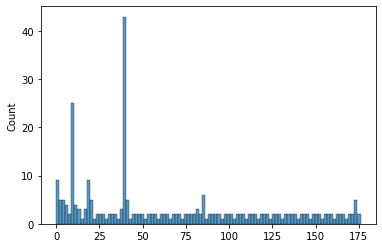

In [24]:
sns.histplot(data = clustering, bins = 100)